In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl

In [4]:
#folium module install
#pip install folium

In [5]:
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

In [6]:
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer  #Imputer 모듈 SimpleImputer로 변경
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle   #텍스트 데이터가 아닌 파이썬 객체 자체를 저장

- data load

In [7]:
train = pd.read_csv('/content/drive/MyDrive/캐글 스터디 필사/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('/content/drive/MyDrive/캐글 스터디 필사/nyc-taxi-trip-duration/test.csv')
test.shape, train.shape

((625134, 9), (1458644, 11))

- convert to approrpricate datatype
    - pickup datetime과 dropoff datetime의 데이터를 datetime 객체로 변경
    - 이 과정에서 보여지는 데이터 형태가 달라지는 것은 아님

In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [9]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
#train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'],'%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


- pickup_datetime과 dropoff_datetime 컬럼의 dtype으로 변경되었음

- 결측치 찾기

In [12]:
train[pd.isnull(train)].sum()

id                    0  
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

- 결측치 없음!

- dateset의 산출 기간 확인

In [13]:
print('Min pickup time:', min(train['pickup_datetime']))
print('Max pickup time:', max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


In [14]:
train['pickup_datetime'].apply(lambda x : x.weekday())
train = train[0:-1]
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458638,id1454193,2,2016-02-02 00:39:39,2016-02-02 00:46:33,5,-73.988823,40.736553,-73.989166,40.757393,N,414
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764


- 1월 1일 00시부터 6월 30일 23시 59분까지

- pickup datetime 컬럼에서 day, month, hour 생성

In [15]:
#pickup
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

#dropoff
train['dropoff_date']= train['dropoff_datetime'].dt.date
train['dropoff_day']=train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour']=train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week']=train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])




- 위도와 경도를 소수점 셋째자리로 반올림한 컬럼 생성

In [16]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x:round(x,3))

In [17]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


- 위도와 경도를 활용하여 km 거리 측정

- 지구는 둥그므로 단순 직선거리를 측정하면 오차 발생
    - so, 하버사인 거리 측정
    - https://kayuse88.github.io/haversine/

In [18]:
def calculateDistance(row):
    R = 6373.0 # 지구의 대략적인 반지름(단위 km)
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2) **2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    distance = R * c
    
    return distance

In [19]:
train['trip_distance'] = train.apply(lambda row : calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [20]:
train['trip_duration']

0          455 
1          663 
2          2124
3          429 
4          435 
          ...  
1458638    414 
1458639    778 
1458640    655 
1458641    764 
1458642    373 
Name: trip_duration, Length: 1458643, dtype: int64

In [21]:
# 초를 기준으로 작성된 trip_duration 컬럼을 hour 단위로 변경하여 새로운 컬럼에 저장
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x:x/3600)

In [22]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458638,id1454193,2,2016-02-02 00:39:39,2016-02-02 00:46:33,5,-73.988823,40.736553,-73.989166,40.757393,N,...,2016-02-02,2,0,Tuesday,40.737,-73.989,40.757,-73.989,2.318176,0.115000
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2016-04-08,8,13,Friday,40.746,-73.982,40.740,-73.995,1.225465,0.216111
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2016-01-10,10,7,Sunday,40.747,-74.001,40.797,-73.970,6.051735,0.181944
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2016-04-22,22,7,Friday,40.769,-73.959,40.707,-74.004,7.827062,0.212222


In [23]:
train.shape

(1458643, 25)

- 탐색적 분석

Text(0.5, 0, 'Trip Duration (in hour)')

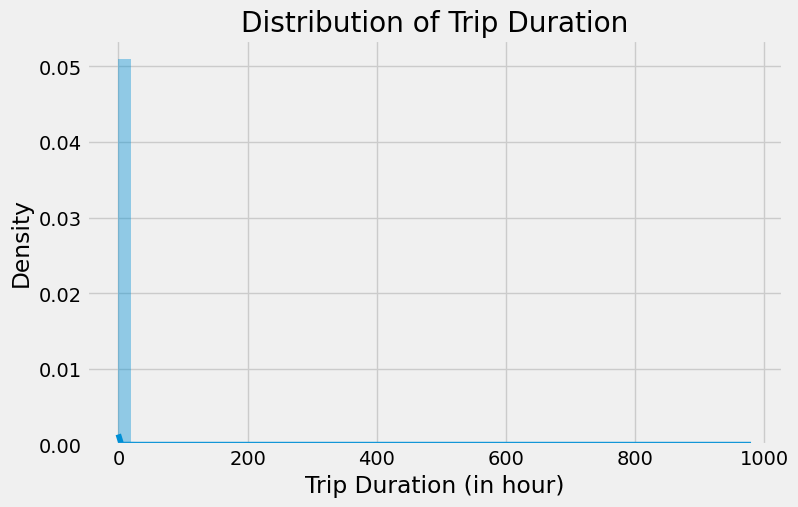

In [24]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel('Trip Duration (in hour)')

- trip duration 이 24시간 넘는 데이터 확인

In [25]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


- 아웃라이어 데이터는 4개
- 위치가 시작하고 끝나는 특별한 데이터가 있는지?
- trip duration skewed되어있으므로 로그변환
- 아웃라이어 데이터는 테스트 데이터 예측을 위해 그대로 두기

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

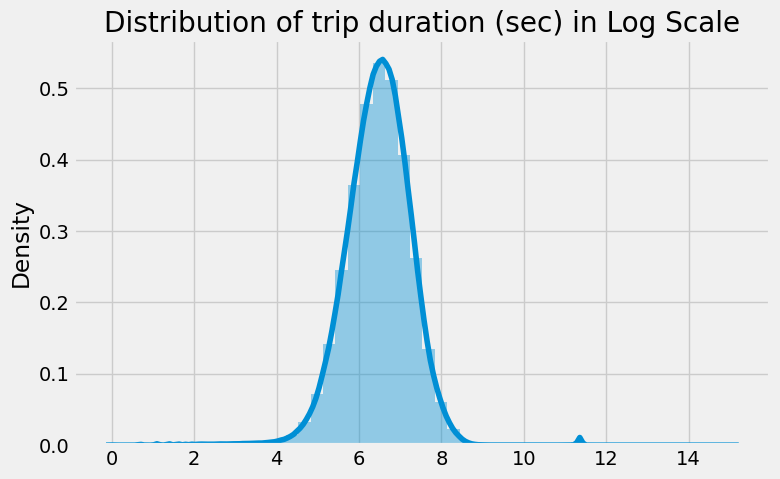

In [26]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values))
plt.title("Distribution of trip duration (sec) in Log Scale")

- 로그 변환으로 trip duration 컬럼이 정규분포를 띔
- 대부분의 trip이 한시간 이내 라는 것을 의미
- 단, 1분 이내 인것도 있으므로 세세하게 봐야함
- 100시간이 넘는 것도 있음

- 픽업, 드랍이 이뤄지는 위치 히트맵으로 표현

In [27]:
# 픽업 위치(위도와 경도)를 그룹으로 묶고 각 아이디의 개수를 카운트, 인덱스는 픽업위치별로 다시 인덱싱 numtrip으로 표현
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id' : 'Num_Trips'})

In [28]:
pickup

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1
...,...,...,...
13019,43.140,-72.591,1
13020,43.487,-74.195,1
13021,43.912,-71.882,1
13022,44.372,-66.972,1


In [29]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10)



In [30]:
#pickup df를 리스트형으로 변경
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.astype(float).values)),
                  min_opactiy=0.2,
                  radius=5,
                  blur=15,
                  max_zoom=1)




In [31]:
pickup_map.add_child(hm_wide)
pickup_map

In [32]:
TMP = list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.astype(float).values))
type(TMP[1][0])

numpy.float64

(-74.03, -73.75)

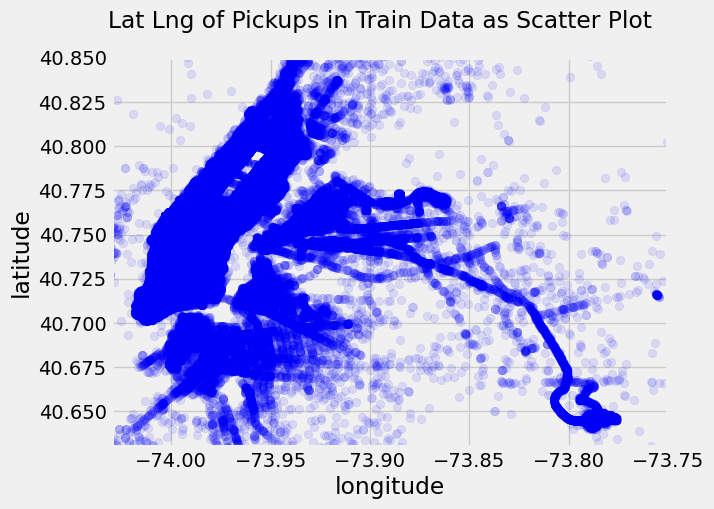

In [33]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           color='blue', label='train', alpha=0.1)
fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

# 위에서 도시 경계를 튜플형태로 지정하고 그래프의 리밋으로 활용
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

- pickup 위도와 경도를 그래프레 표시, 진할 수록 빈도가 잦음을 의미
- 공항에 픽업 빈도가 많음을 확인

- dropoff의 경우에도 동일하게 확인
  - dropoff 위도와 경도를 그룹으로 묶고 아이디의 개수를 카운트
  

In [34]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id' : 'Num_Trips'})

In [35]:
drop_map = folium.Map(location = [40.730610, -73.935242], zoom_start =10)

hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.astype(float).values)),
                  min_opacity = 0.2,
                  radius =5,
                  blur = 15,
                  max_zoom=1)

drop_map.add_child(hm_wide)
drop_map

- trip duration에 대한 히트맵

In [36]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration' : 'Avg_Trip_duration'})

In [37]:
pickup
# 픽업 위치에 따른 평균 여행시간
# 소수점 셋째자리 반올림하고 그룹바이하면 생각보다 많이 준다

,pickup_latitude_round3,pickup_longitude_round3,Avg_Trip_duration
0,34.360,-65.848,961.0
1,34.712,-75.354,875.0
2,35.082,-71.800,611.0
3,35.310,-72.074,317.0
4,36.029,-77.441,782.0
...,...,...,...
13019,43.140,-72.591,799.0
13020,43.487,-74.195,674.0
13021,43.912,-71.882,632.0
13022,44.372,-66.972,1131.0


In [38]:
pickup_map = folium.Map(location = [40.730610, -73.935242], zoom_start = 10)

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

In [39]:
# jfk에서 출발할 경우 여행시간이 길다

In [40]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


pickup, dropoff 중 어떤 경우 더 늦은 시간인지?

Text(0.5, 1.0, 'Pickup Hours Distribution')

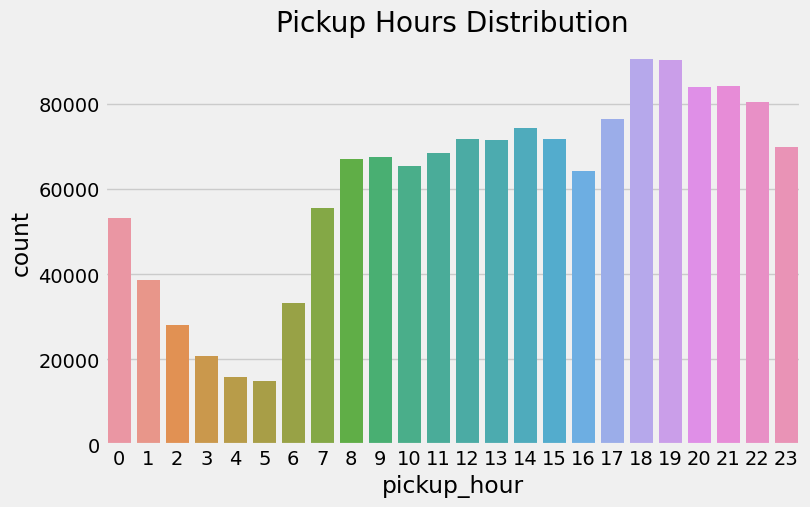

In [41]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

In [42]:
# 새벽시간이 낮고 18~19시간이 많음

Text(0.5, 1.0, 'Dropoff Hours Distribution')

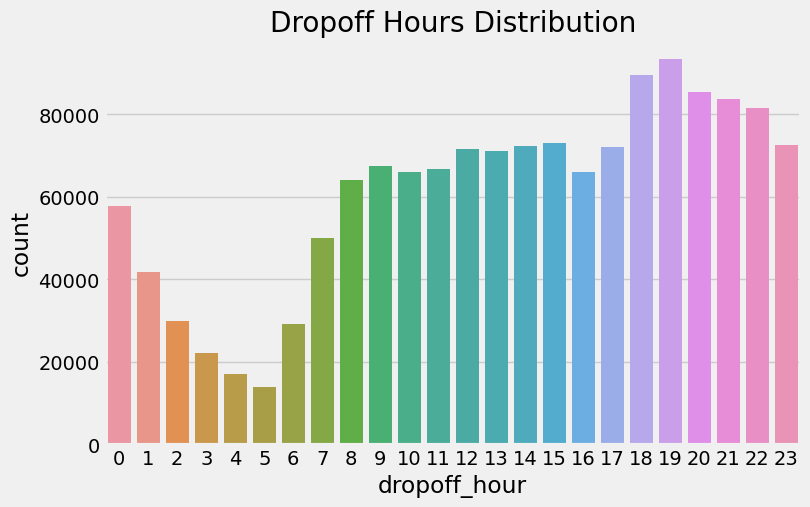

In [43]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title('Dropoff Hours Distribution')

In [44]:
# 이 시각화가 무슨 의미가 있지..? trip duration은 보통 한시간 이내이고 dropoffhour는 pickuphour에 따라오는? 분포를 가질텐데..

- 전체 기간 중 pickup 분포

Text(0.5, 1.0, 'Distribution of Pickups over time')

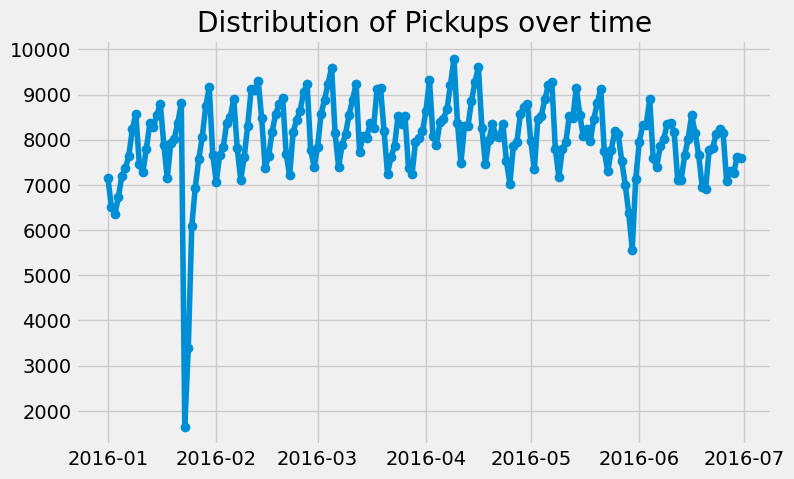

In [45]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')

plt.title('Distribution of Pickups over time')

In [46]:
# 1월에 특별히 떨어지는 시기가 있음

- trip 거리의 분포

Text(0.5, 0, 'Trip Distance (log)')

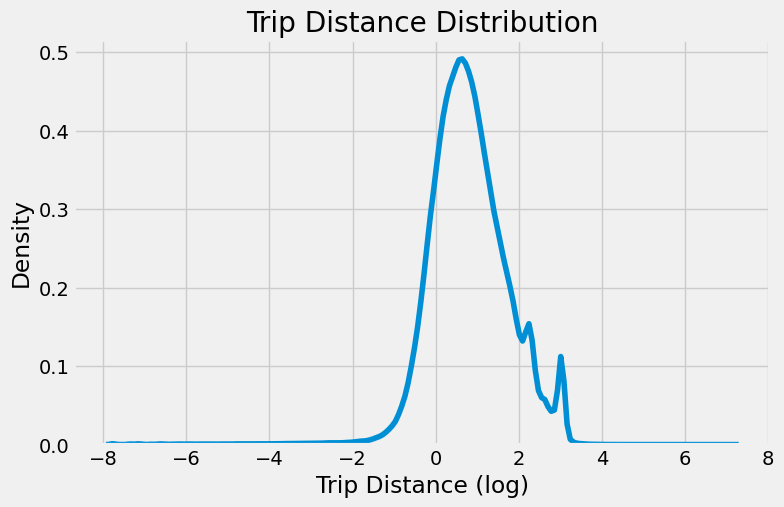

In [47]:
plt.figure(figsize = (8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title('Trip Distance Distribution')
plt.xlabel('Trip Distance (log)')

In [48]:
# sns.kdeplot(train['trip_distance'])
# log 변환하지 않고 그래프 그리는 경우 skewed 때문에 정확하게 확인 불가

- Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

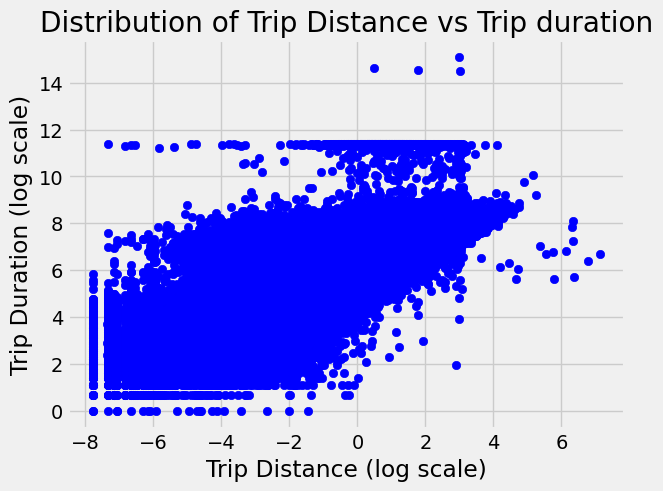

In [49]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color = 'blue', label = 'train')

plt.title('Distribution of Trip Distance vs Trip duration')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Trip Duration (log scale)')

In [50]:
# 여행거리가 높아질 수록 시간이 길어지는 경향이나, 거리가 짧은데도 시간이 오래 걸리는 경우도 있음 = > 차가 막힐때 그럴 수 있겠다

- 시간대마다 여행 시간의 차이가 있는지? 분포 확인

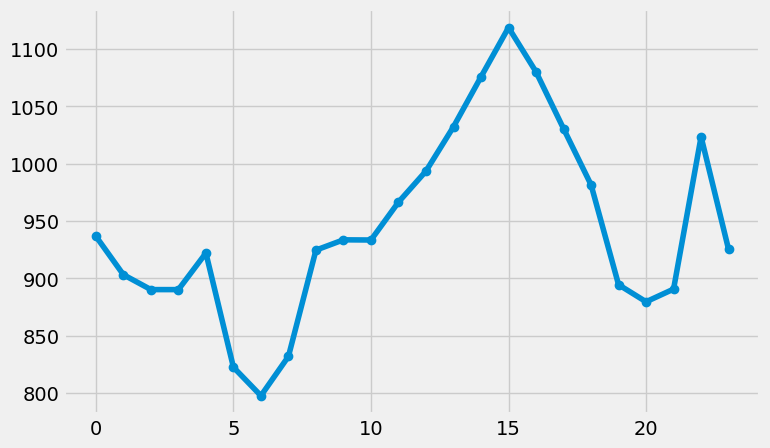

In [51]:
# 픽업 시간대별 평균 여행시간 계산
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration' : 'avg_duration_hour'})

plt.figure(figsize = (8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),  'o-')

In [52]:
# 10~15시에 탈 경우 여행 시간이 길어짐

In [53]:
train[['pickup_neighbourhood']]

KeyError: ignored

- 요일별 픽업의 분포

In [54]:
plt.figure(figsize=(8,5))
sns.barplot(data = temp, x='index', y='pickup_day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])


NameError: ignored

<Figure size 800x500 with 0 Axes>

<Axes: xlabel='pickup_day_of_week', ylabel='count'>

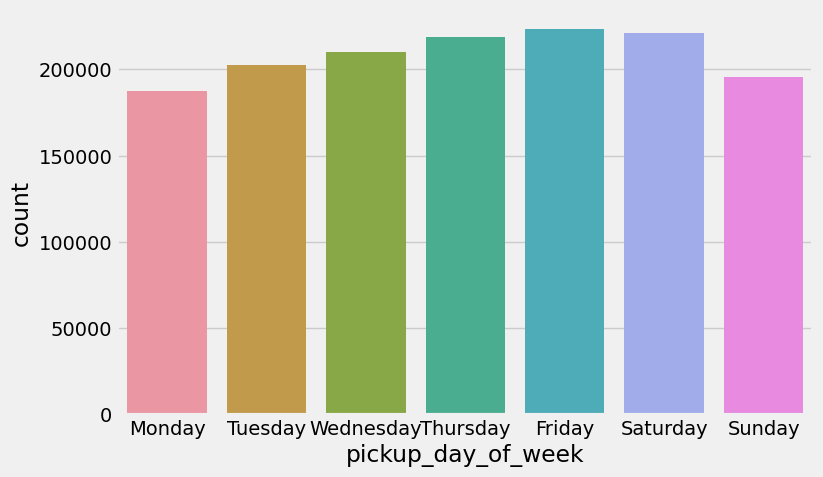

In [55]:
plt.figure(figsize=(8,5))
sns.countplot(data = train[['pickup_day_of_week']], x='pickup_day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])


In [56]:
temp = pd.DataFrame(train['pickup_day_of_week'].value_counts()).reset_index()
temp

,index,pickup_day_of_week
0,Friday,223533
1,Saturday,220868
2,Thursday,218574
3,Wednesday,210136
4,Tuesday,202748
5,Sunday,195366
6,Monday,187418


- 월요일의 픽업이 가장 적음

- Avg Trip Duration over Days of week

In [57]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

In [58]:
# 요일별 운행 기간 확인, 어떤 요일이 가장 운행시간이 긴지?
avg_duration_day

,pickup_day_of_week,avg_trip_duration
0,Friday,990.224200
1,Monday,897.947839
2,Saturday,948.051175
3,Sunday,901.639395
4,Thursday,1006.528654
5,Tuesday,983.466998
6,Wednesday,975.450494


Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

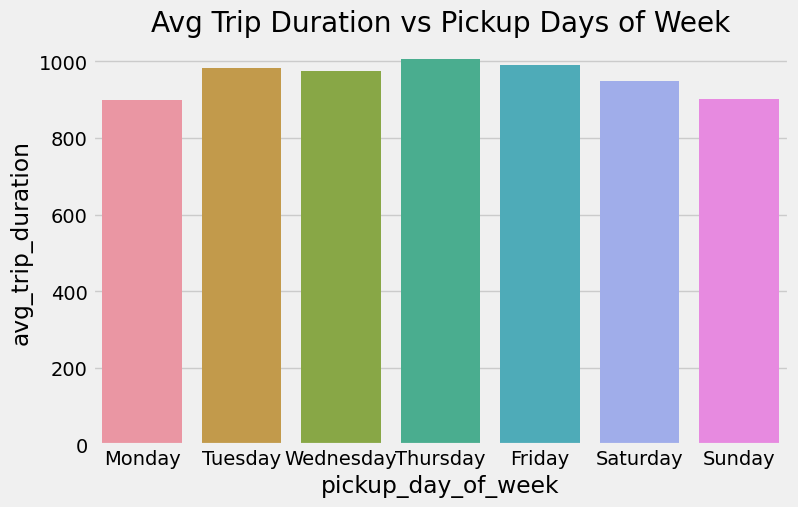

In [59]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title('Avg Trip Duration vs Pickup Days of Week')

- 목요일의 운행기간이 가장 길다

- create a caluclated field Bearing : 여행의 방향 확인



In [60]:
def calculateBearing(lat1, lng1, lat2, lng2):
  R = 6371
  
  # 경도를 통해 해당 각도의 라디안 구하기 
  lng_delta_rad = np.radians(lng2 - lng1)

  #map(function, iterable), 라디안을 적용한 값 반환
  lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
  
  # The function calculates the y and x components of a vector pointing from the starting point to the ending point, 
  # using the Haversine formula for great-circle distance
  y = np.sin(lng_delta_rad) * np.cos(lat2)
  x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)

  return np.degrees(np.arctan2(y,x))

In [61]:
train['bearing'] = train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'],
                                                           row['dropoff_longitude_round3']), axis=1)

- Distribution of Bearing

<Axes: xlabel='bearing', ylabel='Density'>

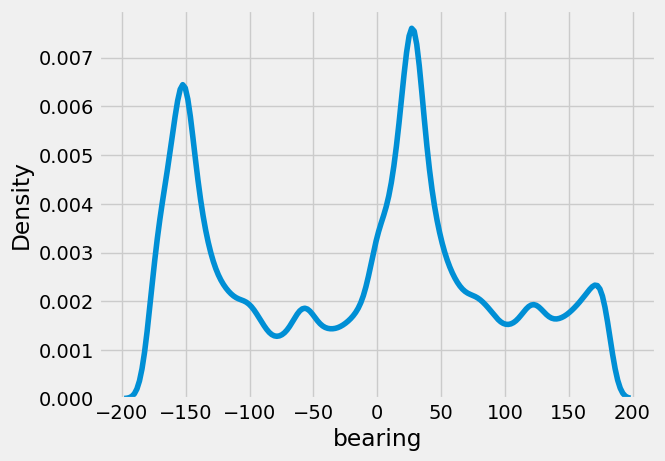

In [62]:
sns.kdeplot(train['bearing'])

- Bearing vs Trip Duration

Text(0, 0.5, 'Trip duration (log scale)')

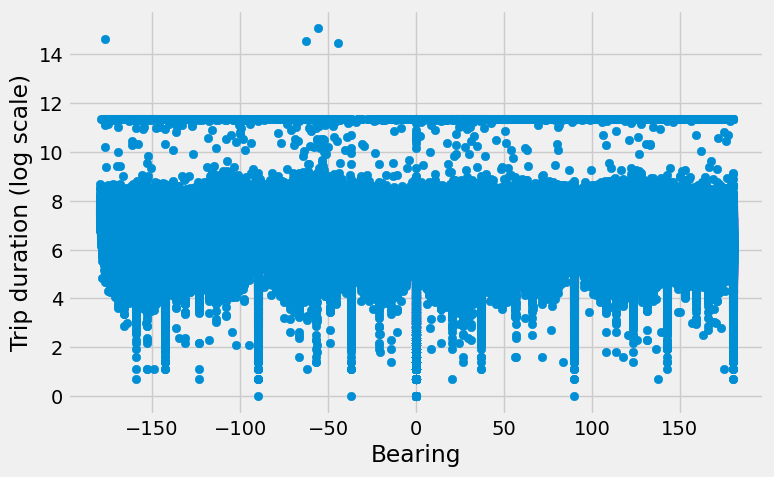

In [63]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel('Bearing')
plt.ylabel('Trip duration (log scale)')

In [64]:
# -50 방향일 경우 아웃라이어가 있음

- Distribution of Store and FWD Flag

In [65]:
#store_and_fwd_flag - 
# 이 플래그는 차량이 서버에 연결되지 않았기 때문에 차량 메모리에 트립 기록이 저장되어 있는지 여부를 나타냅니다(Y=저장 후 전달, N=저장 후 전달 트립이 아님).
train['store_and_fwd_flag'].value_counts()

N    1450598
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

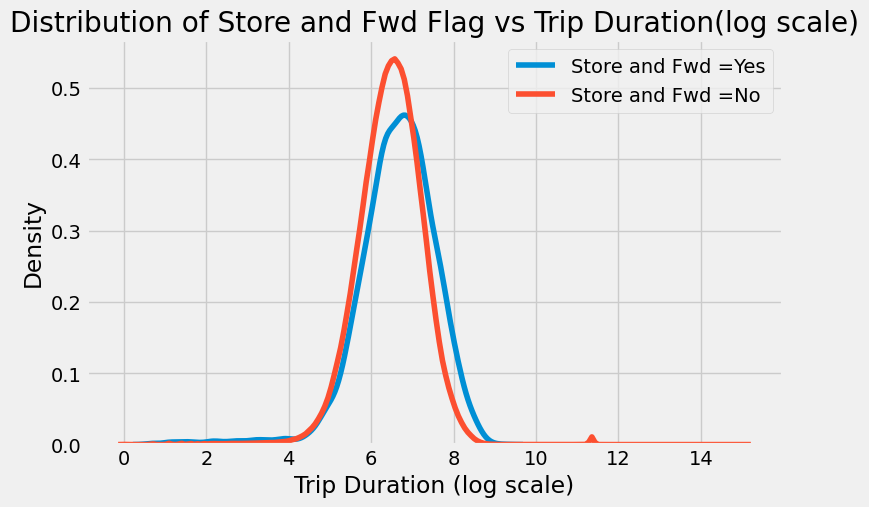

In [66]:
plt.figure(figsize=(8,5))

sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration'].values), label='Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration'].values), label='Store and Fwd =No')

plt.legend()
plt.title('Distribution of Store and Fwd Flag vs Trip Duration(log scale)')
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

In [67]:
# store and Fwd no 인 경우 trip Duration의 밀도가 더 높다

- Group Locations into cluster
: 위치를 그룹별로 묶어 클러스터로 표현


In [68]:
# train, test data의 픽업 위도 경도, 드랍 위도 경도를 vertical로 병합
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [69]:
# 8개 클러스터를 지정하여 fit
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)


In [70]:
# kmeans로 예측한 값을 픽업 드랍별로 컬럼에 생성
train['pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

# train.loc[:, '~~~"] 랑 위에랑 어차피 똑같은거 아닌가? 왜 굳이 loc를 사용?

In [71]:
kmeans.predict(train[['pickup_latitude', 'pickup_longitude']]).shape

(1458643,)

In [72]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

(-74.03, -73.75)

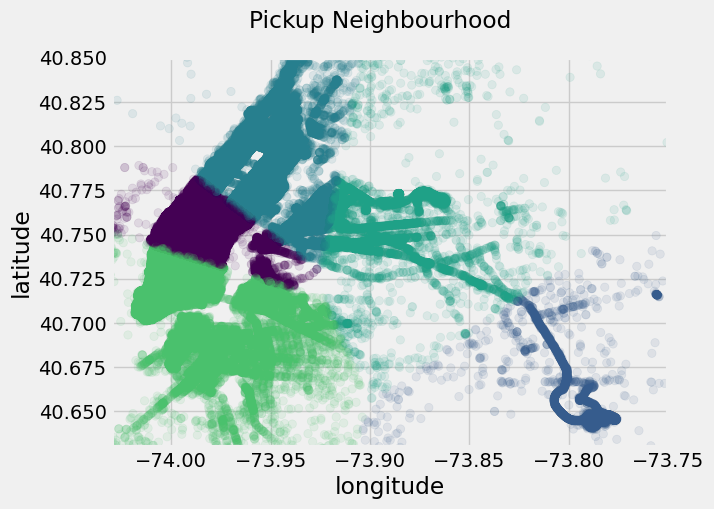

In [73]:
#clustet별로 픽업 위치 시각화
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
                 c = train['pickup_neighbourhood'], label = 'train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

- Number of pickups in each neighbourhood: 각 클러스터별 픽업의 수
- 어디에서 가장 많이 픽업되는지?

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourshoods')

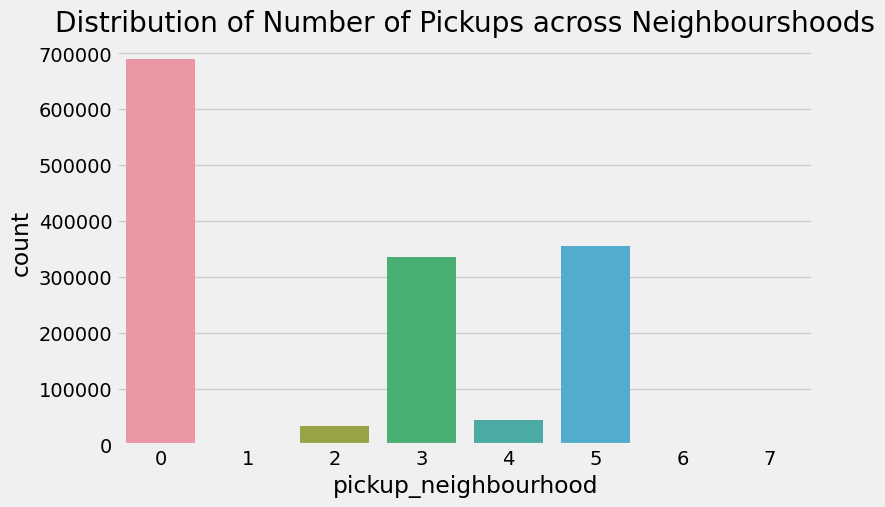

In [74]:
plt.figure(figsize=(8,5))
sns.countplot(data=train[['pickup_neighbourhood']], x='pickup_neighbourhood').set_title('Distribution of Number of Pickups across Neighbourshoods')

In [75]:
# 0구간에서 가장 많이 픽업됨!

In [76]:
train[['pickup_neighbourhood']].value_counts()

pickup_neighbourhood
0                       689971
5                       355704
3                       335005
4                       44621 
2                       33323 
7                       11    
6                       6     
1                       2     
dtype: int64

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourgood')

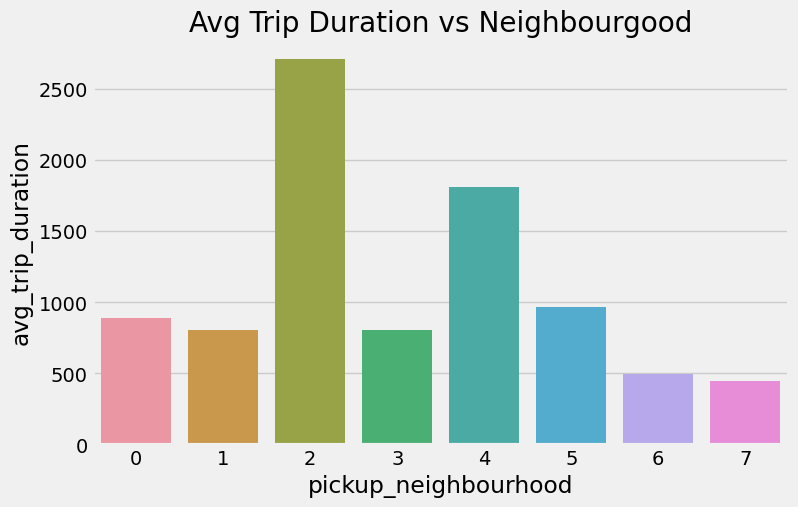

In [77]:
# 클러스터별 운행기간 확인
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))

sns.barplot(x='pickup_neighbourhood', y='avg_trip_duration', data=avg_duration_neighbourhood).set_title('Avg Trip Duration vs Neighbourgood')

In [78]:
# 2구간에서 탈 경우 평균 운행기간이 길다!

- Distribution of Average speed : 평균 속도의 분포 
속도는 거리분의 시간을 이용하여 계산

Text(0.5, 1.0, 'Distribution of Average Speed')

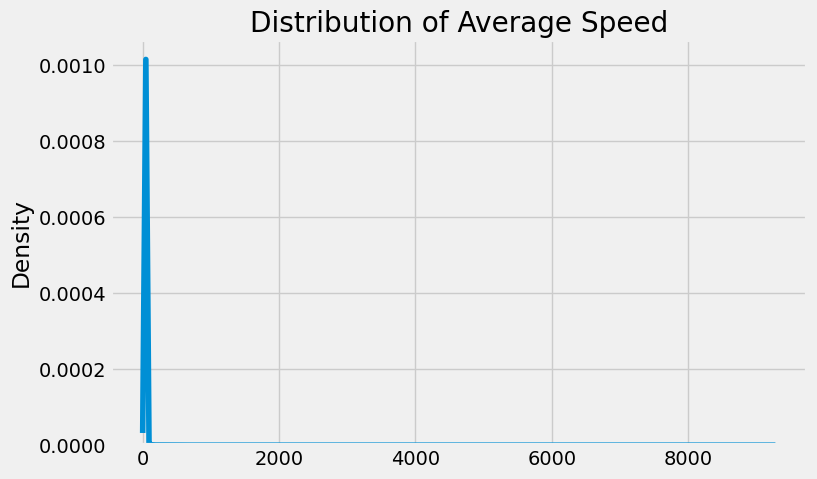

In [79]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']

plt.figure(figsize=(8,5))

sns.kdeplot(train['avg_speed_kph'].values).set_title('Distribution of Average Speed')

In [80]:
# 평균 속도는?
print('Average speed is', np.mean(train['avg_speed_kph']), 'kph')

Average speed is 14.427732489523095 kph


- Average Speed across days of week : 요일별 평균 속도
- 어느 요일이 가장 막힐까?

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

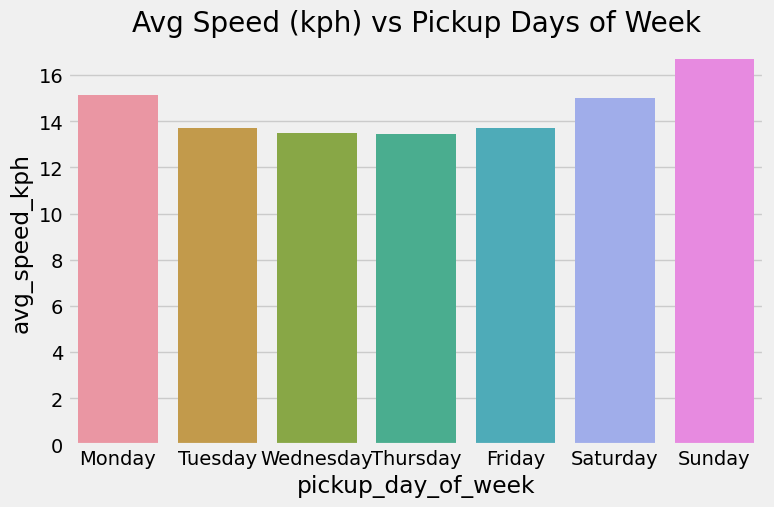

In [81]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()

plt.figure(figsize=(8,5))

sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data = avg_speed_per_day,
            order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title('Avg Speed (kph) vs Pickup Days of Week')

In [82]:
# 월요일과 토, 일요일이 가장 막힘

- Feature Engineering on Test Data

In [83]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])


- Building Models

In [84]:
# 필요없는 데이터 드랍
# dropoff datetime featues랑 위도 경도 소수점 3째자리로 변환한 데이터만 살리기

In [85]:
drop_cols = ['avg_speed_kph', 'trip_duration_in_hour', 'dropoff_date', 'dropoff_day', 'dropoff_hour',
             'dropoff_day_of_week', 'dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

training = train.drop(drop_cols, axis=1)

testing = test.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

In [86]:
# 예측할 trip duration 을 log로 변환하기
training['log_trip_duration'] = training['trip_duration'].apply(lambda x:np.log(x))

training.drop(['trip_duration'], axis =1, inplace = True)

In [87]:
print('Training Data Shape', training.shape)
print('Testing Data Shape', testing.shape)


Training Data Shape (1458643, 18)
Testing Data Shape (625134, 17)


In [88]:
# 요일을 숫자로 인코딩하는 함수를 정의
def encodeDays(day_of_week):
  day_dict={'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
  return day_dict[day_of_week]

In [89]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))


In [90]:
training.to_csv('input_training.csv', index=False)
testing.to_csv('input_testing.csv', index=False)

In [91]:
del training
del testing
del train
del test

In [95]:
# 타입이 2개 이하인 경우에만 레이블 인코딩
def LabelEncoding(train_df, test_df, max_levels=2):
  for col in train_df:
    # train data의 컬럼 데이터 타입이 object일 경우
    if train_df[col].dtype == 'object':
      # unique한 값이 2개 이하일 경우 레이블인코더를 이용하여 인코딩
      if len(list(train_df[col].unique())) <= max_levels:
        le = preprocessing.LabelEncoder()
        le.fit(train_df[col])
        train_df[col]=le.transform(train_df[col])
        test_df[col]=le.transform(test_df[col])
  return [train_df, test_df]

In [97]:
def readInputAndEncode(input_path, train_file, test_file, target_column):
  training = pd.read_csv(input_path + train_file)
  testing = pd.read_csv(input_path + test_file)

  training, testing = LabelEncoding(training, testing)

  train_cols = training.columns.tolist()
  test_cols = testing.columns.tolist()
  
  col_in_train_not_test = set(train_cols) - set(test_cols)

  for col in col_in_train_not_test:
    if col!= target_column:
      testing[col] = 0
      col_in_train_not_test = set(train_cols) - set(test_cols)

  for col in col_in_train_not_test:
    training[col] = 0

  print('Training Data Shape aftet processing', training.shape)
  print('Testing Data Shape after Processing', testing.shape)

  return[training, testing]



        

In [98]:
train, test = readInputAndEncode('/content/', 'input_training.csv', 'input_testing.csv', 'log_trip_duration')


Training Data Shape aftet processing (1458643, 18)
Testing Data Shape after Processing (625134, 17)


In [99]:
#픽업 날짜와 픽업 시간대를 드랍
train.drop(['pickup_date'], axis=1, inplace=True)
test.drop(['pickup_date'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)
test.drop(['pickup_datetime'], axis=1, inplace=True)

#test id를 별도 시리즈로 저장하고 트레인, 테스트 데이터에서는 드랍
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [105]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True):
  labels=np.array(train[target])
  training = train.drop(target, axis =1)
  training = np.array(training)
  testing = np.array(test)

  # 결측치를 미디안으로 채우는 과정
  if imputation == True:
    imputer = SimpleImputer(strategy=imputing_strategy, missing_values=np.nan)
    # training data에 대해 fit하고 transform은 training, testing data 각각 처리
    imputer.fit(training)
    training=SimpleImputer.transfrom(training)
    testing=SimpleImputer.transform(testing)

  train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state =42)
  return [train_features, validation_features, train_labels, validation_labels, testing]

In [106]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train, test, 'log_trip_duration', imputation=False)

In [107]:
# train, validation 데이터 분리, label도 각각 분리
train_features, validation_features, train_labels, validation_labels, testing

(array([[   1.        ,    1.        ,    0.        , ...,  170.44056557,
            0.        ,    5.        ],
        [   1.        ,    1.        ,    0.        , ..., -162.00974689,
            0.        ,    5.        ],
        [   2.        ,    1.        ,    0.        , ..., -100.17067874,
            4.        ,    0.        ],
        ...,
        [   2.        ,    1.        ,    0.        , ...,   39.73260249,
            5.        ,    3.        ],
        [   1.        ,    1.        ,    0.        , ...,  -71.72963801,
            3.        ,    3.        ],
        [   2.        ,    1.        ,    0.        , ..., -105.40477548,
            4.        ,    0.        ]]),
 array([[   2.        ,    1.        ,    0.        , ...,   10.72265652,
            0.        ,    0.        ],
        [   2.        ,    1.        ,    0.        , ..., -142.8520388 ,
            0.        ,    0.        ],
        [   2.        ,    5.        ,    0.        , ...,   67.57940677,

- Apply Linear Regression

In [108]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)


LinearRegression()

In [109]:
valid_pred = lm.predict(validation_features)

In [118]:
rmse = mean_squared_error(validation_labels, valid_pred)
print('Root Mean Squared Error for Linear Regression(log scale)', rmse)

Root Mean Squared Error for Linear Regression(log scale) 0.0


In [113]:
test_pred = lm.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('submission_linear_regression_vaseline.csv', index=False)
del submit

- Apply Random Forest Regressor

In [114]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features,train_labels)


RandomForestRegressor(random_state=42)

In [116]:
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

Root Mean Squared Error for Random Forest 0.0


In [119]:
test_pred = rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('submission_random_forest_baseline.csv', index=False)

In [ ]:
q